# Model - Saved Dictionary

### Imports

In [1]:
import os
import pandas as pd
from iqual import iqualnlp, evaluation, crossval, vectorizers

### Load `annotated (human-coded)` and `unannotated` datasets

In [2]:
data_dir         = "../../data"
human_coded_df   = pd.read_csv(os.path.join(data_dir,"annotated.csv"))
uncoded_df       = pd.read_csv(os.path.join(data_dir,"unannotated.csv"))

### Create vectors using `spacy` or `sentence-transformers` and save them as a pickle file

In [3]:
dict_dir        = "../../dictionaries"
os.makedirs(dict_dir,exist_ok=True)

In [4]:
text_df   = pd.concat([human_coded_df,uncoded_df],axis=0)
sentences = pd.unique(text_df[['Q_en','A_en']].values.ravel())
print(f"{len(sentences)} unique sentences")

53623 unique sentences


### Create a precomputed dictionary using the `sentence-transformer` package

In [5]:
sentence_transformer_models = ["all-mpnet-base-v2", "all-roberta-large-v1","distiluse-base-multilingual-cased-v2","all-MiniLM-L6-v2"]

for model in sentence_transformer_models:        
    vectorizer       = vectorizers.SentenceTransformerVectorizer(model)
    sentence_vectors = vectorizer.transform(sentences,
                                            convert_to_numpy=True,
                                            batch_size=64,
                                            device='cuda' ## If cuda is available, use device='cuda' for faster vectorization
                                           )
    sentence_vector_dict = dict(zip(sentences,sentence_vectors))
    dictionary_path  = os.path.join(dict_dir,model+".pkl")
    vectorizers.save_pickle_data(sentence_vector_dict,dictionary_path)

### Create a precomputed dictionary using the `spacy` package

In [6]:
spacy_models = ["en_core_web_sm","en_core_web_md","en_core_web_lg"]

for model in spacy_models:
    vectorizer       = vectorizers.SpacyVectorizer(model)
    sentence_vectors = vectorizer.transform(sentences)
    sentence_vector_dict = dict(zip(sentences,sentence_vectors))
    dictionary_path  = os.path.join(dict_dir,model+".pkl")
    vectorizers.save_pickle_data(sentence_vector_dict, dictionary_path)

### Split the data into training and test sets

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(human_coded_df,test_size=0.25)
print(f"Train Size: {len(train_df)}\nTest Size: {len(test_df)}")

Train Size: 7470
Test Size: 2490


### Configure training data

In [8]:
### Select Question and Answer Columns
question_col = 'Q_en'
answer_col   = 'A_en'

### Select a code
code_variable = 'marriage'

### Create X and y
X = train_df[[question_col,answer_col]]
y = train_df[code_variable]

### Initiate model

In [9]:
# Step 1: Initiate the model class
iqual_model = iqualnlp.Model()

# Step 2: Add layers to the model
#  Add text columns, and choose a feature extraction model (Available options: scikit-learn, spacy, sentence-transformers, saved-dictionary (picklized dictionary))
iqual_model.add_text_features(question_col,answer_col,model='../dictionaries/all-mpnet-base-v2.pkl',env='saved-dictionary')

# Step 3: Add a feature transforming layer (optional)
# A. Choose a feature-scaler. Available options: 
# any scikit-learn scaler from `sklearn.preprocessing`
iqual_model.add_feature_transformer(name='Normalizer', transformation="FeatureScaler")
# OR
# B. Choose a dimensionality reduction model. Available options:
# - Any scikit-learn dimensionality reduction model from `sklearn.decomposition`
# - Uniform Manifold Approximation and Projection (UMAP) using umap.UMAP (https://umap-learn.readthedocs.io/en/latest/)

### iqual_model.add_feature_transformer(name='PCA', transformation="DimensionalityReduction")

# Step 4: Add a classifier layer
# Choose a primary classifier model  (Available options: any scikit-learn classifier)
iqual_model.add_classifier(name="LogisticRegression")

# Step 5: Add a threshold layer. This is optional, but recommended for binary classification
iqual_model.add_threshold(scoring_metric='f1')

# Step 6: Compile the model
iqual_model.compile()

Pipeline(steps=[('Input',
                 FeatureUnion(transformer_list=[('question',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function column_selector at 0x00000192AFF18A60>,
                                                                                      kw_args={'column_name': 'Q_en'})),
                                                                 ('vectorizer',
                                                                  Vectorizer(env='saved-dictionary',
                                                                             model='../dictionaries/all-mpnet-base-v2.pkl'))])),
                                                ('answer',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTrans...
                ('FeatureTransformation', FeatureScaler(copy=True, norm='l2')),
                ('Classifier',
                 Classifier(C=1.0, class_weight=None, dual=False,
                            fit_intercept=True, intercept_scaling=1,
                            l1_ratio=None, max_iter=100,
                            model='LogisticRegression', multi_class='auto',
                            n_jobs=None, penalty='l2', random_state=None,
                            solver='lbfgs', tol=0.0001, verbose=0,
                            warm_start=False)),
                ('Threshold', BinaryThresholder())])

### Configure a Hyperparameter Grid for cross-validation + fitting

In [15]:
model_paths = [os.path.join(dict_dir,model+'.pkl') for model in [*spacy_models,*sentence_transformer_models]]

search_param_config = {
    "Input":{
        "question":{
            "vectorizer":{
                        "model":model_paths,
                         "env":["saved-dictionary"],               
                         },
        },
        "answer":{
            "vectorizer":{
                        "model":model_paths,
                        "env":["saved-dictionary"],                
                         },                        
        },
    },
        "Classifier":{
            "model":["LogisticRegression"],
            "C":[0.01,0.1],
        },
}

CV_SEARCH_PARAMS = crossval.convert_nested_params(search_param_config)

print(CV_SEARCH_PARAMS)

{'Input__question__vectorizer__model': ['../../dictionaries\\en_core_web_sm.pkl', '../../dictionaries\\en_core_web_md.pkl', '../../dictionaries\\en_core_web_lg.pkl', '../../dictionaries\\all-mpnet-base-v2.pkl', '../../dictionaries\\all-roberta-large-v1.pkl', '../../dictionaries\\distiluse-base-multilingual-cased-v2.pkl', '../../dictionaries\\all-MiniLM-L6-v2.pkl'], 'Input__question__vectorizer__env': ['saved-dictionary'], 'Input__answer__vectorizer__model': ['../../dictionaries\\en_core_web_sm.pkl', '../../dictionaries\\en_core_web_md.pkl', '../../dictionaries\\en_core_web_lg.pkl', '../../dictionaries\\all-mpnet-base-v2.pkl', '../../dictionaries\\all-roberta-large-v1.pkl', '../../dictionaries\\distiluse-base-multilingual-cased-v2.pkl', '../../dictionaries\\all-MiniLM-L6-v2.pkl'], 'Input__answer__vectorizer__env': ['saved-dictionary'], 'Classifier__model': ['LogisticRegression'], 'Classifier__C': [0.01, 0.1]}


## Model training:
Cross-validate over hyperparameters and select the best model

In [16]:
# Scoring Dict for evaluation
scoring_dict = {'f1':evaluation.get_scorer('f1')}

cv_dict = iqual_model.cross_validate_fit(
    X,y,                                # X: Pandas DataFrame of features, y: Pandas Series of labels
    search_parameters=CV_SEARCH_PARAMS, # search_parameters: Dictionary of parameters to use for cross-validation
    cv_method='GridSearchCV',           # cv_method: Cross-validation method to use, options: GridSearchCV, RandomizedSearchCV
    scoring=scoring_dict,               # scoring: Scoring metric to use for cross-validation
    refit='f1',                         # refit: Metric to use for refitting the model
    n_jobs=-1,                          # n_jobs: Number of parallel threads to use  
    cv_splits=3,                        # cv_splits: Number of cross-validation splits
)
print()
print("Average F1 score: {:.3f}".format(cv_dict['avg_test_score']))

.......98 hyperparameters configurations possible.....
Average F1 score: 0.837


### Evaluate model using out sample data (Held out human-coded data)

In [20]:
test_X = test_df[['Q_en','A_en']]
test_y = test_df[code_variable]

f1_score  = iqual_model.score(test_X,test_y,
                              scoring_function=evaluation.get_metric('f1_score'))
print(f"Out-sample F1-score: {f1_score:.3f}")

accuracy  = iqual_model.score(test_X,test_y,
                              scoring_function=evaluation.get_metric('accuracy_score'))
print(f"Out-sample accuracy-score: {accuracy:.3f}")

Out-sample F1-score: 0.785
Out-sample accuracy-score: 0.980


### Predict labels for unannotated data

<AxesSubplot:>

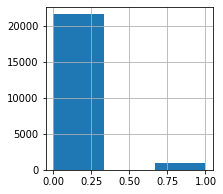

In [18]:
uncoded_df[code_variable+'_pred'] = iqual_model.predict(uncoded_df[['Q_en','A_en']])

uncoded_df[code_variable+"_pred"].hist(figsize=(3,3),bins=3)

### Examples for positive predictions

In [19]:
for idx, row in uncoded_df.loc[(uncoded_df[code_variable+"_pred"]==1),['Q_en','A_en']].sample(3).iterrows():
    print("Q: ",row['Q_en'],"\n","A: ", row['A_en'],sep='')
    print()

Q: What are your dreams and hopes for your daughter?
A: There is hope, I will study, study, become a doctor, then find a good boy and get married.

Q: Yes, yes. When the girl grows up, don't you have such a dream about the girl? I want to know if there is any other dream like this?
A: I will see my daughter and marry her. I will try to make a doctor.

Q: I mean what have you done for your daughter?
A: How to dress my daughter, how to get her married, how to keep the children happy, that is my problem.

